## **Procurement RFx Timeline Predictor for Industrial Assets**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

df = pd.read_csv('procurement_kpi_analysis_dataset.csv')  
df.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No


---

## Phase 1: EDA + KPI Extraction

**Data info**

In [3]:
df.info()
df.isna().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PO_ID             777 non-null    object 
 1   Supplier          777 non-null    object 
 2   Order_Date        777 non-null    object 
 3   Delivery_Date     690 non-null    object 
 4   Item_Category     777 non-null    object 
 5   Order_Status      777 non-null    object 
 6   Quantity          777 non-null    int64  
 7   Unit_Price        777 non-null    float64
 8   Negotiated_Price  777 non-null    float64
 9   Defective_Units   641 non-null    float64
 10  Compliance        777 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 66.9+ KB


,Quantity,Unit_Price,Negotiated_Price,Defective_Units
count,777.000000,777.000000,777.000000,641.000000
mean,1094.660232,58.283822,53.660721,74.803432
std,647.844551,28.101315,26.094930,69.187870
min,51.000000,10.840000,9.270000,0.000000
25%,615.000000,33.290000,30.460000,26.000000
50%,1075.000000,58.950000,53.800000,49.000000
75%,1548.000000,83.130000,76.550000,100.000000
max,5000.000000,109.170000,107.390000,321.000000


## Cleaning and Preprocessing

**Convert Date Columns to** `datetime`

In [6]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')

**Handle Missing** `Delivery_Date`

In [7]:
df['Delivery_Missing'] = df['Delivery_Date'].isna()

`Lead_Time_Days` **creation**

In [8]:
df['Lead_Time_Days'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

**Missing** `Defective_Units` **handling**

In [9]:
df['Defective_Units'] = df['Defective_Units'].fillna(0)
df['Defect_Info_Missing'] = df['Defective_Units'] == 0 # optional flag

**Feature Engineering**

In [10]:
df['Cost_Saving_Per_Unit'] = df['Unit_Price'] - df['Negotiated_Price']
df['Total_Saving'] = df['Cost_Saving_Per_Unit'] * df['Quantity']
df['Defect_Rate'] = df['Defective_Units'] / df['Quantity']

**Flag Bad Procurement Instances**

In [11]:
df['Flag_High_Defect'] = df['Defect_Rate'] > 0.15
df['Flag_Delay'] = df['Lead_Time_Days'] > 10

---

## Phase 2: KPI Analysis and Visualization

**1. Order Status Breakdown**

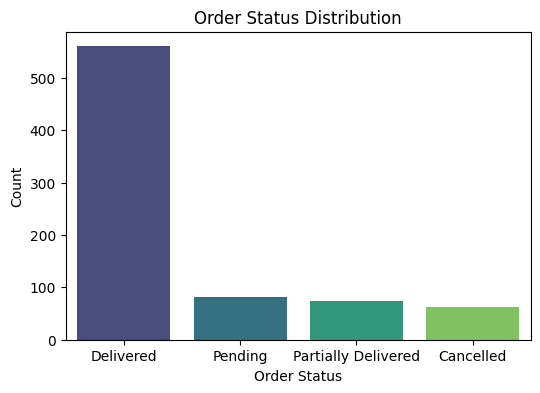

In [20]:
order_status_counts = df['Order_Status'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values, hue=order_status_counts.index, palette='viridis', legend=False)
plt.title('Order Status Distribution')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.show()

**2. Average Lead Time by Item Category**

In [21]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])
df['Lead_Time_Days'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

Grouping by item category:

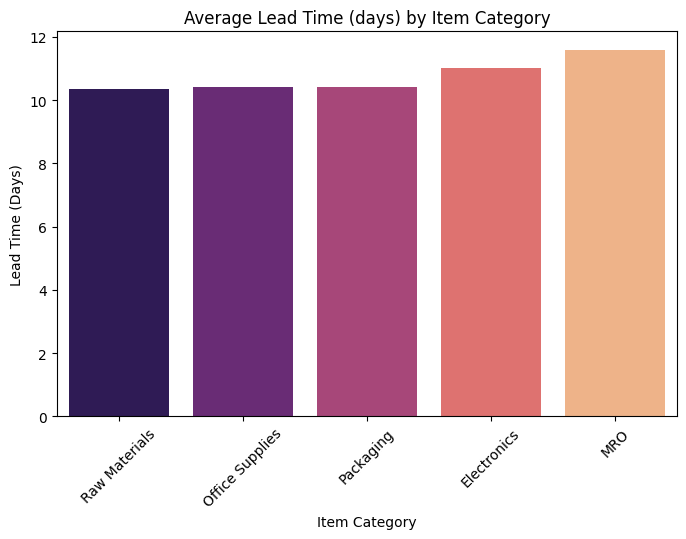

In [25]:
lead_time_by_category = df.groupby('Item_Category')['Lead_Time_Days'].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=lead_time_by_category.index, y=lead_time_by_category.values, hue=lead_time_by_category.index, palette='magma', legend=False)
plt.title('Average Lead Time (days) by Item Category')
plt.xticks(rotation=45)
plt.ylabel('Lead Time (Days)')
plt.xlabel('Item Category')
plt.show()

**3. Defect Rate Summary by Supplier**

Defect rate calculation per order list:

In [26]:
df['Defect_Rate'] = df['Defective_Units'] / df['Quantity']

**Now, Average `defect rate` by supplier:**

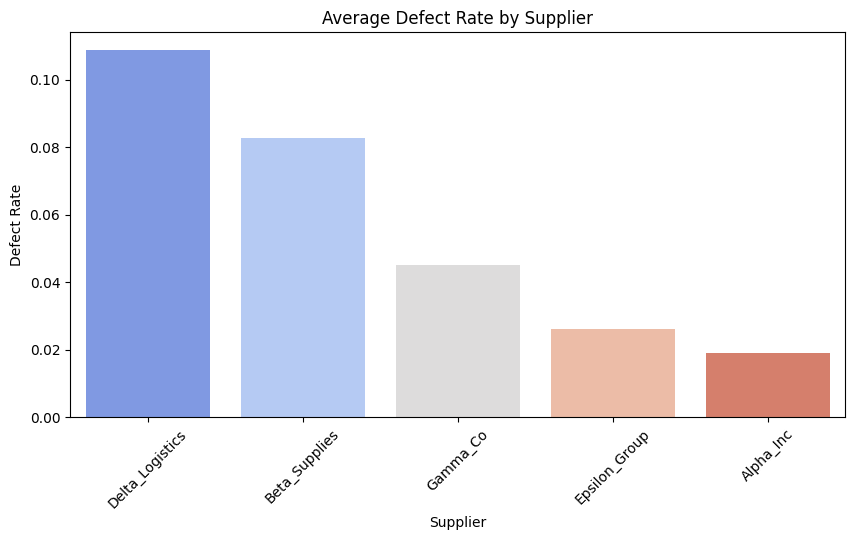

In [28]:
defect_rate_by_supplier = df.groupby('Supplier')['Defect_Rate'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=defect_rate_by_supplier.index, y=defect_rate_by_supplier.values, hue=defect_rate_by_supplier.index, palette='coolwarm', legend=False)
plt.title('Average Defect Rate by Supplier')
plt.xticks(rotation=45)
plt.ylabel('Defect Rate')
plt.xlabel('Supplier')
plt.show()

**4. Cost Savings Analysis**

**`Savings per order` calculation**

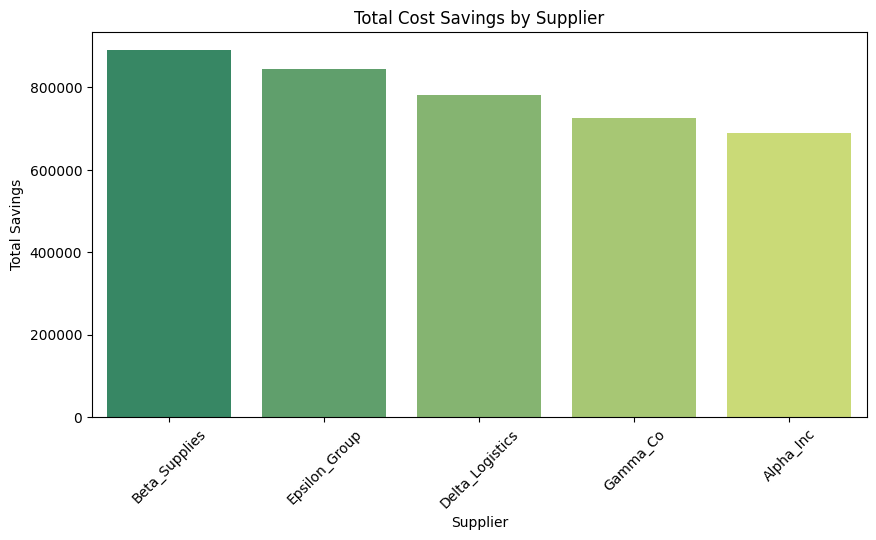

In [30]:
savings_by_supplier = df.groupby('Supplier')['Total_Saving'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=savings_by_supplier.index, y=savings_by_supplier.values, hue=savings_by_supplier.index, palette='summer', legend=False)
plt.title('Total Cost Savings by Supplier')
plt.xticks(rotation=45)
plt.ylabel('Total Savings')
plt.xlabel('Supplier')
plt.show()

**5. Compliance Rate by Item Category**

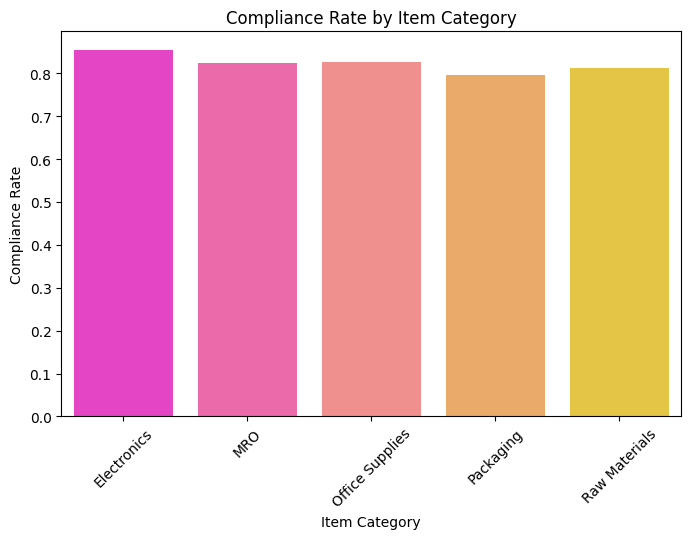

In [32]:
df['Compliance_Flag'] = df['Compliance'].map({'Yes': 1, 'No': 0})

compliance_rate = df.groupby('Item_Category')['Compliance_Flag'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=compliance_rate.index, y=compliance_rate.values, hue=compliance_rate.index, palette='spring', legend=False)
plt.title('Compliance Rate by Item Category')
plt.xticks(rotation=45)
plt.ylabel('Compliance Rate')
plt.xlabel('Item Category')
plt.show()

**6. Pie Chart: Compliance Distribution Overall**

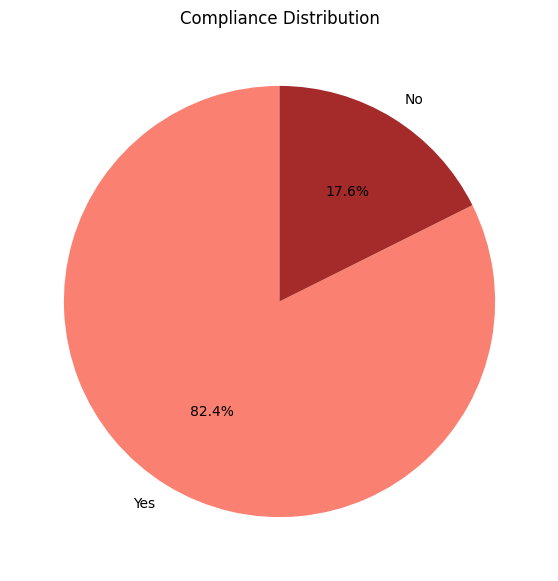

In [46]:
compliance_counts = df['Compliance'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(compliance_counts, labels=compliance_counts.index, autopct='%1.1f%%', colors=['salmon', 'brown'], startangle=90)
plt.title('Compliance Distribution')
plt.show()


**7. Monthly Order Volume Trend**

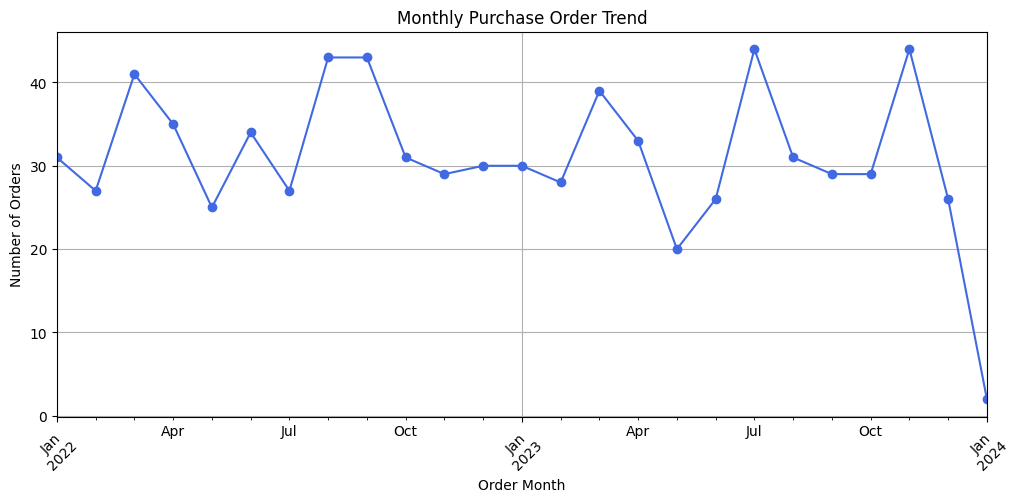

In [35]:
df['Order_Month'] = df['Order_Date'].dt.to_period('M')

monthly_orders = df.groupby('Order_Month').size()

plt.figure(figsize=(12,5))
monthly_orders.plot(kind='line', marker='o', color='royalblue')
plt.title('Monthly Purchase Order Trend')
plt.xlabel('Order Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**8. Quantity vs. Defective Units (Size = Negotiated Price)**

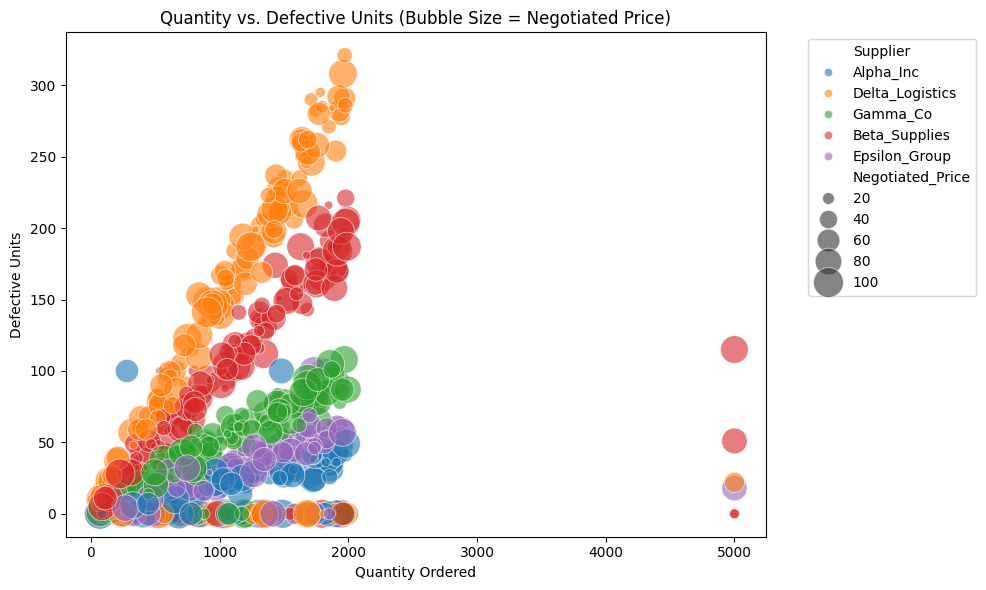

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Quantity',
    y='Defective_Units',
    size='Negotiated_Price',
    hue='Supplier',
    palette='tab10',
    alpha=0.6,
    sizes=(20, 500)
)
plt.title('Quantity vs. Defective Units (Bubble Size = Negotiated Price)')
plt.xlabel('Quantity Ordered')
plt.ylabel('Defective Units')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


---

## Phase 3: BI-Style Analysis & Automation Readiness

**Goal:** Extract actionable business insights + prepare automation-ready outputs for dashboards, using **Microsoft Power BI**

**Step 1: Feature Engineering – Add Lead Time, Savings, etc.**

In [47]:
# Convert dates
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])

# Lead time in days
df['Lead_Time'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

# % Savings
df['Savings_Percentage'] = ((df['Unit_Price'] - df['Negotiated_Price']) / df['Unit_Price']) * 100

# Order Size Category
df['Order_Size'] = pd.cut(df['Quantity'],
                          bins=[0, 700, 1300, df['Quantity'].max()],
                          labels=['Low', 'Medium', 'High'])

# Extract year, month
df['Order_Year'] = df['Order_Date'].dt.year
df['Order_MonthName'] = df['Order_Date'].dt.strftime('%B')
df['Order_Weekday'] = df['Order_Date'].dt.day_name()

df.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance,Delivery_Missing,Lead_Time_Days,Defect_Info_Missing,Cost_Saving_Per_Unit,Total_Saving,Defect_Rate,Flag_High_Defect,Flag_Delay,Compliance_Flag,Order_Month,Lead_Time,Savings_Percentage,Order_Size,Order_Year,Order_MonthName,Order_Weekday
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,0.0,Yes,False,8.0,True,2.32,2728.32,0.000000,False,False,1,2023-10,8.0,11.525087,Medium,2023,October,Tuesday
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes,False,10.0,False,1.98,2987.82,0.155732,True,False,1,2022-04,10.0,5.035605,High,2022,April,Monday
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes,False,20.0,False,3.25,2957.50,0.045055,False,True,1,2022-01,20.0,3.402785,Medium,2022,January,Wednesday
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes,False,19.0,False,4.33,5819.52,0.083333,False,True,1,2022-10,19.0,4.336505,High,2022,October,Sunday
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No,False,12.0,False,3.54,4177.20,0.144915,False,True,0,2022-09,12.0,5.525207,Medium,2022,September,Thursday


**Step 2: Business KPIs Table (Power BI Aggregation Style)**

Computing a summary table with these columns for each supplier:
```
=> Total Orders
=> Avg Lead Time
=> Avg % Savings
=> Compliance Rate
=> Avg Defect Rate
=> Total Spend 
=> Category Coverage
=> etc.
```

In [49]:
summary_df = df.groupby('Supplier').agg({
    'PO_ID': 'count',
    'Lead_Time': 'mean',
    'Savings_Percentage': 'mean',
    'Compliance': lambda x: (x == 'Yes').mean() * 100,
    'Defect_Rate': 'mean',
    'Total_Saving': 'sum',
    'Negotiated_Price': lambda x: (x * df.loc[x.index, 'Quantity']).sum(),
    'Flag_Delay': 'sum',
    'Flag_High_Defect': 'sum',
    'Item_Category': pd.Series.nunique
}).reset_index()

# Renaming for clarity
summary_df.columns = [
    'Supplier', 'Total_Orders', 'Avg_Lead_Time', 'Avg_Savings_%',
    'Compliance_%', 'Avg_Defect_Rate', 'Total_Saving',
    'Total_Spend_Negotiated', 'Delayed_Orders', 'High_Defect_Orders',
    'Category_Coverage'
]

summary_df = summary_df.round(2)
summary_df.head()


,Supplier,Total_Orders,Avg_Lead_Time,Avg_Savings_%,Compliance_%,Avg_Defect_Rate,Total_Saving,Total_Spend_Negotiated,Delayed_Orders,High_Defect_Orders,Category_Coverage
0,Alpha_Inc,141,10.61,8.21,93.62,0.02,688920.49,7839712.25,67,1,5
1,Beta_Supplies,156,11.27,7.83,75.64,0.08,889940.89,9858665.90,80,0,5
2,Delta_Logistics,171,10.85,7.81,60.82,0.11,781976.49,9236240.47,81,62,5
3,Epsilon_Group,166,10.87,8.04,98.19,0.03,844980.18,9851156.06,81,1,5
4,Gamma_Co,143,10.19,7.98,86.01,0.04,725308.42,8587921.71,61,0,5


**Exporting the Table:**

In [50]:
summary_df.to_csv('powerbi_summary_supplier_kpis.csv', index=False)

**Step 3: Supplier Risk & Opportunity Segmentation (Mini RFx Tracker)**

Now that we have all flags and insights, let’s segment suppliers into:
Segmentation Logic:

| Segment          | Criteria                                                        |
| ---------------- | --------------------------------------------------------------- |
|  **Reliable**    | High compliance (≥90%), Low defect rate (≤5%), No delays        |
|  **Watchlist**   | Moderate compliance (70–90%), Some delays or high defect rate   |
|  **High Risk**   | Low compliance (<70%) OR Many delays OR High defect rate (>10%) |
|  **Opportunity** | High savings % (>7%), Medium/High orders, low delays            |


Code:

In [52]:
def segment_supplier(row):
    if row['Compliance_%'] >= 90 and row['Avg_Defect_Rate'] <= 0.05 and row['Delayed_Orders'] == 0:
        return 'Reliable'
    elif row['Compliance_%'] < 70 or row['Avg_Defect_Rate'] > 0.1 or row['Delayed_Orders'] > 2:
        return 'High Risk'
    elif row['Avg_Savings_%'] > 7 and row['Total_Orders'] >= 3 and row['Delayed_Orders'] <= 1:
        return 'Opportunity'
    else:
        return 'Watchlist'

summary_df['Supplier_Segment'] = summary_df.apply(segment_supplier, axis=1)
summary_df[['Supplier', 'Supplier_Segment']].head()


,Supplier,Supplier_Segment
0,Alpha_Inc,High Risk
1,Beta_Supplies,High Risk
2,Delta_Logistics,High Risk
3,Epsilon_Group,High Risk
4,Gamma_Co,High Risk


Export for Power BI

In [53]:
summary_df.to_csv('supplier_risk_segments.csv', index=False)

---

## Phase 4: Procurement Efficiency Metrics

This phase is divided into 4 logical blocks:

**4.1 Organization-Level Summary KPIs**

In [54]:
org_summary = {
    'Total Orders': df.shape[0],
    'Total Suppliers': df['Supplier'].nunique(),
    'Total Cost Saved (₹)': round(df['Total_Saving'].sum(), 2),
    'Avg Lead Time (Days)': round(df['Lead_Time_Days'].mean(), 2),
    'Avg Defect Rate (%)': round(df['Defect_Rate'].mean() * 100, 2),
    'Delayed Orders Count': df['Flag_Delay'].sum(),
    'High Defect Orders Count': df['Flag_High_Defect'].sum(),
    'Overall Compliance Rate (%)': round(df['Compliance_Flag'].mean() * 100, 2)
}
pd.DataFrame.from_dict(org_summary, orient='index', columns=["Value"])

,Value
Total Orders,777.00
Total Suppliers,5.00
Total Cost Saved (₹),3931126.47
Avg Lead Time (Days),10.78
Avg Defect Rate (%),5.78
Delayed Orders Count,370.00
High Defect Orders Count,64.00
Overall Compliance Rate (%),82.37


**4.2 Monthly Trend of Cost Savings**

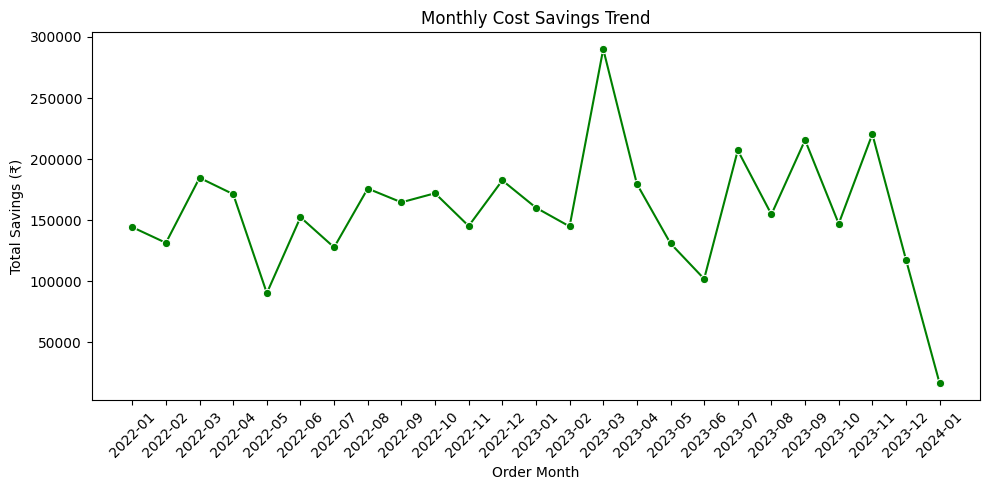

In [65]:
df['Total_Saving'] = pd.to_numeric(df['Total_Saving'], errors='coerce')
df['Order_Month'] = pd.to_datetime(df['Order_Date']).dt.to_period('M').astype(str)
monthly_savings = df.groupby('Order_Month')['Total_Saving'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_savings, x='Order_Month', y='Total_Saving', marker='o', color='green')
plt.title("Monthly Cost Savings Trend")
plt.xlabel("Order Month")
plt.ylabel("Total Savings (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.3 Lead Time by Item Category**

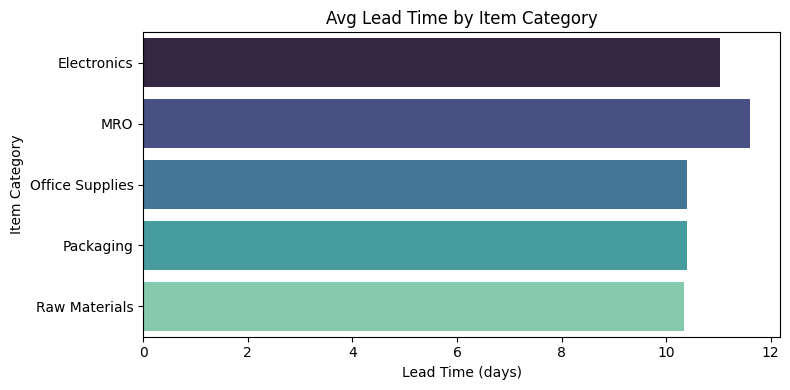

In [59]:
category_lead = df.groupby('Item_Category')['Lead_Time_Days'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=category_lead, x='Lead_Time_Days', y='Item_Category', hue='Item_Category', palette='mako', legend=False)
plt.title("Avg Lead Time by Item Category")
plt.xlabel("Lead Time (days)")
plt.ylabel("Item Category")
plt.tight_layout()
plt.show()


**4.4 Supplier Delay & Defect Heatmap**

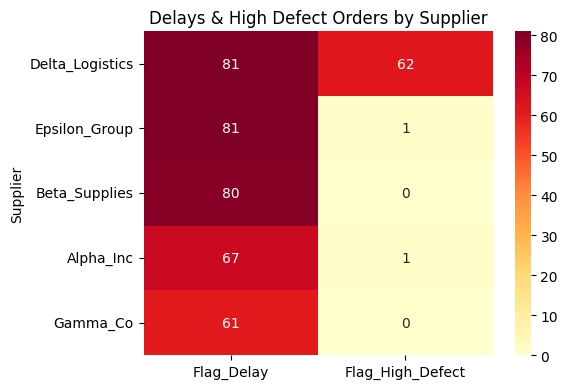

In [63]:
supplier_perf = df.groupby('Supplier').agg({
    'Flag_Delay': 'sum',
    'Flag_High_Defect': 'sum'
}).reset_index().sort_values(by='Flag_Delay', ascending=False)

plt.figure(figsize=(6, 4))
sns.heatmap(supplier_perf.set_index('Supplier'), annot=True, cmap='YlOrRd', fmt='g')
plt.title("Delays & High Defect Orders by Supplier")
plt.ylabel("Supplier")
plt.tight_layout()
plt.show()


---